##### Copyright 2020 Google LLC.


Licensed under the Apache License, Version 2.0 (the 'License');
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an 'AS IS' BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

### This colab contains TensorFlow code for implementing the constrained optimization methods presented in the paper:
> Harikrishna Narasimhan, Andrew Cotter, Maya Gupta, Serena Wang, 'Pairwise Fairness for Ranking and Regression', AAAI 2020. [<a href='https://arxiv.org/pdf/1906.05330.pdf'>link</a>]

### The original implementation can be found here:
> https://github.com/google-research/google-research/blob/master/pairwise_fairness/ranking_crime.ipynb

### Our version uses packages from Fairlearn and it's pre/post processing methods to improve on the original paper's results
> Fairlearn documentation is here: https://fairlearn.org/

First, let's install and import the relevant libraries.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import sys
from sklearn import model_selection
import tensorflow as tf

We will need the TensorFlow Constrained Optimization (TFCO) library.

In [2]:
!pip install git+https://github.com/google-research/tensorflow_constrained_optimization --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
beatrix-jupyterlab 3.1.7 requires google-cloud-bigquery-storage, which is not installed.
xarray-einstats 0.2.2 requires numpy>=1.21, but you have numpy 1.19.5 which is incompatible.
tfx-bsl 1.9.0 requires pyarrow<6,>=1, but you have pyarrow 8.0.0 which is incompatible.
tfx-bsl 1.9.0 requires tensorflow!=2.0.*,!=2.1.*,!=2.2.*,!=2.3.*,!=2.4.*,!=2.5.*,!=2.6.*,!=2.7.*,!=2.8.*,<3,>=1.15.5, but you have tensorflow 2.6.4 which is incompatible.
tensorflow-transform 1.9.0 requires pyarrow<6,>=1, but you have pyarrow 8.0.0 which is incompatible.
tensorflow-transform 1.9.0 requires tensorflow!=2.0.*,!=2.1.*,!=2.2.*,!=2.3.*,!=2.4.*,!=2.5.*,!=2.6.*,!=2.7.*,!=2.8.*,<2.10,>=1.15.5, but you have tensorflow 2.6.4 which is incompatible.
tens

In [3]:
import tensorflow_constrained_optimization as tfco

In [4]:
# import fairlearn
!pip install fairlearn --quiet
import fairlearn

## Pairwise Ranking Fairness

We will be training a linear ranking model $f(x) = w^\top x$ where $x \in \mathbb{R}^d$ is a set of features for a query-document pair. Our goal is to train the model such that it accurately ranks the positive documents in a query above the negative ones.


Specifically, for the ranking model $f$, we denote:
- $err(f)$ as the pairwise ranking error for model $f$ over all pairs of positive and negative documents
$$
err(f) = \mathbf{E}\big[\mathbb{I}\big(f(x) < f(x')\big) \,\big|\, y = 1,~ y' = 0\big]
$$


- $err_{i,j}(f)$ as the pairwise ranking error over positive-negative document pairs where the pos. document is from group $i$, and the neg. document is from group $j$.

$$
err_{i, j}(f) = \mathbf{E}\big[\mathbb{I}\big(f(x) < f(x')\big) \,\big|\, y = 1,~ y' = 0,~ grp(x) = i, ~grp(x') = j\big]
$$
<br>

We then wish to solve the following constrained problem:
$$min_f\; err(f)$$
$$\text{   s.t.   } |err_{i,j}(f) - err_{k,\ell}(f)| \leq \epsilon \;\;\; \forall ((i,j), (k,\ell)) \in \mathcal{G},$$

where $\mathcal{G}$ contains the pairs we are interested in constraining.

## Load Communities & Crime Data

We will use the benchmark Communities and Crimes dataset from the UCI Machine Learning repository for our illustration. This dataset contains various demographic and racial distribution details (aggregated from census and law enforcement data sources) about different communities in the US, along with the per capita crime rate in each commmunity. As is commonly done in the literature, we will bin the crime rate attribute into two categories: "low crime" and "high crime", and formulate the task of *ranking* the communities such that the high crime ones are above the low crime ones. We consider communities where the percentage of black population is above the 70-th percentile as the protected group.


In [5]:
# We will divide the data into 10 batches, and treat each of them as a query.
num_queries = 10

# List of column names in the dataset.
column_names = ["state", "county", "community", "communityname", "fold", "population", "householdsize", "racepctblack", "racePctWhite", "racePctAsian", "racePctHisp", "agePct12t21", "agePct12t29", "agePct16t24", "agePct65up", "numbUrban", "pctUrban", "medIncome", "pctWWage", "pctWFarmSelf", "pctWInvInc", "pctWSocSec", "pctWPubAsst", "pctWRetire", "medFamInc", "perCapInc", "whitePerCap", "blackPerCap", "indianPerCap", "AsianPerCap", "OtherPerCap", "HispPerCap", "NumUnderPov", "PctPopUnderPov", "PctLess9thGrade", "PctNotHSGrad", "PctBSorMore", "PctUnemployed", "PctEmploy", "PctEmplManu", "PctEmplProfServ", "PctOccupManu", "PctOccupMgmtProf", "MalePctDivorce", "MalePctNevMarr", "FemalePctDiv", "TotalPctDiv", "PersPerFam", "PctFam2Par", "PctKids2Par", "PctYoungKids2Par", "PctTeen2Par", "PctWorkMomYoungKids", "PctWorkMom", "NumIlleg", "PctIlleg", "NumImmig", "PctImmigRecent", "PctImmigRec5", "PctImmigRec8", "PctImmigRec10", "PctRecentImmig", "PctRecImmig5", "PctRecImmig8", "PctRecImmig10", "PctSpeakEnglOnly", "PctNotSpeakEnglWell", "PctLargHouseFam", "PctLargHouseOccup", "PersPerOccupHous", "PersPerOwnOccHous", "PersPerRentOccHous", "PctPersOwnOccup", "PctPersDenseHous", "PctHousLess3BR", "MedNumBR", "HousVacant", "PctHousOccup", "PctHousOwnOcc", "PctVacantBoarded", "PctVacMore6Mos", "MedYrHousBuilt", "PctHousNoPhone", "PctWOFullPlumb", "OwnOccLowQuart", "OwnOccMedVal", "OwnOccHiQuart", "RentLowQ", "RentMedian", "RentHighQ", "MedRent", "MedRentPctHousInc", "MedOwnCostPctInc", "MedOwnCostPctIncNoMtg", "NumInShelters", "NumStreet", "PctForeignBorn", "PctBornSameState", "PctSameHouse85", "PctSameCity85", "PctSameState85", "LemasSwornFT", "LemasSwFTPerPop", "LemasSwFTFieldOps", "LemasSwFTFieldPerPop", "LemasTotalReq", "LemasTotReqPerPop", "PolicReqPerOffic", "PolicPerPop", "RacialMatchCommPol", "PctPolicWhite", "PctPolicBlack", "PctPolicHisp", "PctPolicAsian", "PctPolicMinor", "OfficAssgnDrugUnits", "NumKindsDrugsSeiz", "PolicAveOTWorked", "LandArea", "PopDens", "PctUsePubTrans", "PolicCars", "PolicOperBudg", "LemasPctPolicOnPatr", "LemasGangUnitDeploy", "LemasPctOfficDrugUn", "PolicBudgPerPop", "ViolentCrimesPerPop"]

dataset_url = "http://archive.ics.uci.edu/ml/machine-learning-databases/communities/communities.data"

# Read dataset from the UCI web repository and assign column names.
data_df = pd.read_csv(dataset_url, sep=",", names=column_names,
                      na_values="?")

# Make sure that there are no missing values in the "ViolentCrimesPerPop" column.
assert(not data_df["ViolentCrimesPerPop"].isna().any())

# Binarize the "ViolentCrimesPerPop" column and obtain labels.
crime_rate_70_percentile = data_df["ViolentCrimesPerPop"].quantile(q=0.7)
labels_df = (data_df["ViolentCrimesPerPop"] >= crime_rate_70_percentile)

# Now that we have assigned binary labels, 
# we drop the "ViolentCrimesPerPop" column from the data frame.
data_df.drop(columns="ViolentCrimesPerPop", inplace=True)

# Group features.
race_black_70_percentile = data_df["racepctblack"].quantile(q=0.7)
groups_df = (data_df["racepctblack"] >= race_black_70_percentile)

# Drop categorical features.
data_df.drop(columns=["state", "county", "community", "communityname", "fold"],
             inplace=True)

# Handle missing features.
feature_names = data_df.columns
for feature_name in feature_names:  
    missing_rows = data_df[feature_name].isna()  # Which rows have missing values?
    if missing_rows.any():  # Check if at least one row has a missing value.
        data_df[feature_name].fillna(0.0, inplace=True)  # Fill NaN with 0.
        missing_rows.rename(feature_name + "_is_missing", inplace=True)
        data_df = data_df.join(missing_rows)  # Append boolean "is_missing" feature.



In [6]:
labels = labels_df.values.astype(np.float32)
groups = groups_df.values.astype(np.float32)
features = data_df.values.astype(np.float32)

# Set random seed so that the results are reproducible.
np.random.seed(123456)

# We randomly divide the examples into 'num_queries' queries.
queries = np.random.randint(0, num_queries, size=features.shape[0])

# Train, vali and test indices.
train_indices, test_indices = model_selection.train_test_split(
    range(features.shape[0]), test_size=0.4)

# Train features, labels and protected groups.
train_set = {
  'features': features[train_indices, :],
  'labels': labels[train_indices],
  'groups': groups[train_indices],
  'queries': queries[train_indices],
  'dimension': features.shape[-1],
  'num_queries': num_queries
}

# Test features, labels and protected groups.
test_set = {
  'features': features[test_indices, :],
  'labels': labels[test_indices],
  'groups': groups[test_indices],
  'queries': queries[test_indices],
  'dimension': features.shape[-1],
  'num_queries': num_queries
}

In [7]:
trainf = pd.DataFrame(train_set['features'])
testf = pd.DataFrame(test_set['features'])

In [8]:
# get initial correlation matrix
tempRPB = trainf[2]
temptrainf = trainf.drop(columns = 2)
temptrainf['racepctblack'] = tempRPB
corr = temptrainf.corr().head(10)
corrm= corr.iloc[:,-3:]

In [9]:
corr

,0,1,3,4,5,6,7,8,9,10,...,136,137,138,139,140,141,142,143,144,racepctblack
0,1.000000,-0.039435,-0.290395,0.189076,0.141504,0.006570,0.132661,0.079387,-0.101687,0.992058,...,-0.589725,-0.589725,-0.589725,-0.589725,-0.589725,-0.589725,-0.589725,-0.589725,-0.589725,0.227071
1,-0.039435,1.000000,-0.271249,0.175564,0.498336,0.533909,0.396252,0.315250,-0.631286,-0.039985,...,0.100035,0.100035,0.100035,0.100035,0.100035,0.100035,0.100035,0.100035,0.100035,-0.038659
3,-0.290395,-0.271249,1.000000,-0.261594,-0.447743,-0.224386,-0.292822,-0.209016,0.157703,-0.283611,...,0.259303,0.259303,0.259303,0.259303,0.259303,0.259303,0.259303,0.259303,0.259303,-0.795951
4,0.189076,0.175564,-0.261594,1.000000,0.268363,-0.061808,0.073720,0.020941,-0.257837,0.210066,...,-0.121657,-0.121657,-0.121657,-0.121657,-0.121657,-0.121657,-0.121657,-0.121657,-0.121657,-0.107968
5,0.141504,0.498336,-0.447743,0.268363,1.000000,0.163510,0.226091,0.100270,-0.251207,0.138850,...,-0.125955,-0.125955,-0.125955,-0.125955,-0.125955,-0.125955,-0.125955,-0.125955,-0.125955,-0.070606
6,0.006570,0.533909,-0.224386,-0.061808,0.163510,1.000000,0.824851,0.895321,-0.426997,-0.023357,...,0.013597,0.013597,0.013597,0.013597,0.013597,0.013597,0.013597,0.013597,0.013597,0.149228
7,0.132661,0.396252,-0.292822,0.073720,0.226091,0.824851,1.000000,0.931926,-0.534580,0.114475,...,-0.108695,-0.108695,-0.108695,-0.108695,-0.108695,-0.108695,-0.108695,-0.108695,-0.108695,0.171878
8,0.079387,0.315250,-0.209016,0.020941,0.100270,0.895321,0.931926,1.000000,-0.333363,0.056737,...,-0.075244,-0.075244,-0.075244,-0.075244,-0.075244,-0.075244,-0.075244,-0.075244,-0.075244,0.157034
9,-0.101687,-0.631286,0.157703,-0.257837,-0.251207,-0.426997,-0.534580,-0.333363,1.000000,-0.108229,...,0.022972,0.022972,0.022972,0.022972,0.022972,0.022972,0.022972,0.022972,0.022972,0.041102
10,0.992058,-0.039985,-0.283611,0.210066,0.138850,-0.023357,0.114475,0.056737,-0.108229,1.000000,...,-0.602704,-0.602704,-0.602704,-0.602704,-0.602704,-0.602704,-0.602704,-0.602704,-0.602704,0.218815


In [10]:
# import seaborn as sns
# sns.set(rc={'figure.figsize':(6, 6)})
# sns.heatmap(corrm, annot = True)

In [11]:
from fairlearn.preprocessing import CorrelationRemover

cr = CorrelationRemover(sensitive_feature_ids=[2])
dcr = cr.fit_transform(trainf)

rpb = trainf[2]
trainf = pd.DataFrame(dcr)
trainf['racepctblack'] = rpb # rpb to add col back, 0 for group unaware

In [12]:
dcr_test = cr.fit_transform(testf)
trpb = testf[2]
testf = pd.DataFrame(dcr_test)
testf['racepctblack'] = trpb # trpb to add col back, 0 for group unaware

In [13]:
# get preprocessed correlation matrix
precorr = round(trainf.corr(), 3)
precorrm= precorr.iloc[:,-3:].head(10)
precorr

,0,1,2,3,4,5,6,7,8,9,...,135,136,137,138,139,140,141,142,143,racepctblack
0,1.000,-0.032,-0.186,0.221,0.162,-0.028,0.098,0.045,-0.114,0.992,...,-0.566,-0.566,-0.566,-0.566,-0.566,-0.566,-0.566,-0.566,-0.566,-0.0
1,-0.032,1.000,-0.499,0.173,0.497,0.546,0.409,0.326,-0.631,-0.032,...,0.093,0.093,0.093,0.093,0.093,0.093,0.093,0.093,0.093,-0.0
2,-0.186,-0.499,1.000,-0.577,-0.835,-0.176,-0.262,-0.141,0.315,-0.185,...,0.109,0.109,0.109,0.109,0.109,0.109,0.109,0.109,0.109,-0.0
3,0.221,0.173,-0.577,1.000,0.263,-0.046,0.094,0.039,-0.255,0.241,...,-0.154,-0.154,-0.154,-0.154,-0.154,-0.154,-0.154,-0.154,-0.154,-0.0
4,0.162,0.497,-0.835,0.263,1.000,0.176,0.242,0.113,-0.249,0.159,...,-0.148,-0.148,-0.148,-0.148,-0.148,-0.148,-0.148,-0.148,-0.148,-0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,-0.566,0.093,0.109,-0.154,-0.148,0.052,-0.070,-0.038,0.034,-0.580,...,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,-0.0
141,-0.566,0.093,0.109,-0.154,-0.148,0.052,-0.070,-0.038,0.034,-0.580,...,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,-0.0
142,-0.566,0.093,0.109,-0.154,-0.148,0.052,-0.070,-0.038,0.034,-0.580,...,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,-0.0
143,-0.566,0.093,0.109,-0.154,-0.148,0.052,-0.070,-0.038,0.034,-0.580,...,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,-0.0


In [14]:
# import importlib
# importlib.reload(sns)
# sns.heatmap(precorrm, annot = True)

In [15]:
trainf = trainf.values.astype(np.float32)
testf = testf.values.astype(np.float32)

In [16]:
train_set['features'] = trainf
test_set['features'] = testf

## Evaluation Metrics

We will need functions to convert labeled data into paired data.

In [17]:
def pair_pos_neg_docs(data):
  # Returns a DataFrame of pairs of positive-negative docs from given DataFrame.
  # Separate pos and neg docs.
  pos_docs = data[data.label == 1]
  if pos_docs.empty:
    return
  neg_docs = data[data.label == 0]
  if neg_docs.empty:
    return

  # Include a merge key.
  pos_docs.insert(0, 'merge_key', 0)
  neg_docs.insert(0, 'merge_key', 0)

  # Merge docs and drop merge key column.
  pairs = pos_docs.merge(neg_docs, on='merge_key', how='outer',
                         suffixes=('_pos', '_neg'))
  pairs.drop(columns=['merge_key'], inplace=True)
  return pairs


def convert_labeled_to_paired_data(data_dict, index=None):
  # Forms pairs of examples from each batch/query.

  # Converts data arrays to pandas DataFrame with required column names and
  # makes a call to convert_df_to_pairs and returns a dictionary.
  features = data_dict['features']
  labels = data_dict['labels']
  groups = data_dict['groups']
  queries = data_dict['queries']

  if index is not None:
    data_df = pd.DataFrame(features[queries == index, :])
    data_df = data_df.assign(label=pd.DataFrame(labels[queries == index]))
    data_df = data_df.assign(group=pd.DataFrame(groups[queries == index]))
    data_df = data_df.assign(query_id=pd.DataFrame(queries[queries == index]))
  else:
    data_df = pd.DataFrame(features)
    data_df = data_df.assign(label=pd.DataFrame(labels))
    data_df = data_df.assign(group=pd.DataFrame(groups))
    data_df = data_df.assign(query_id=pd.DataFrame(queries))

  # Forms pairs of positive-negative docs for each query in given DataFrame
  # if the DataFrame has a query_id column. Otherise forms pairs from all rows
  # of the DataFrame.
  data_pairs = data_df.groupby('query_id').apply(pair_pos_neg_docs)

  # Create groups ndarray.
  pos_groups = data_pairs['group_pos'].values.reshape(-1, 1)
  neg_groups = data_pairs['group_neg'].values.reshape(-1, 1)
  group_pairs = np.concatenate((pos_groups, neg_groups), axis=1)

  # Create queries ndarray.
  queries = data_pairs['query_id_pos'].values.reshape(-1,)

  # Create features ndarray.
  feature_names = data_df.columns
  feature_names = feature_names.drop(['query_id', 'label'])
  feature_names = feature_names.drop(['group'])

  pos_features = data_pairs[[str(s) + '_pos' for s in feature_names]].values
  pos_features = pos_features.reshape(-1, 1, len(feature_names))

  neg_features = data_pairs[[str(s) + '_neg' for s in feature_names]].values
  neg_features = neg_features.reshape(-1, 1, len(feature_names))

  features_pairs = np.concatenate((pos_features, neg_features), axis=1)

  # Paired data dict.
  paired_data = {
      'features': features_pairs, 
      'groups': group_pairs, 
      'queries': queries,
      'dimension': data_dict['dimension'],
      'num_queries': data_dict['num_queries']
  }

  return paired_data

We will also need functions to evaluate the pairwise error rates for a linear model.

In [18]:
def get_mask(groups, pos_group, neg_group=None):
  # Returns a boolean mask selecting positive-negative document pairs where 
  # the protected group for  the positive document is pos_group and 
  # the protected group for the negative document (if specified) is neg_group.
  # Repeat group membership positive docs as many times as negative docs.
  mask_pos = groups[:, 0] == pos_group
  
  if neg_group is None:
    return mask_pos
  else:
    mask_neg = groups[:, 1] == neg_group
    return mask_pos & mask_neg


def error_rate(model, dataset):
  # Returns error rate for Keras model on dataset.
  d = dataset['dimension']
  scores0 = model.predict(dataset['features'][:, 0, 0:d].reshape(-1, d))
  scores1 = model.predict(dataset['features'][:, 1, 0:d].reshape(-1, d))
  diff = scores0 - scores1  
  return np.mean(diff.reshape((-1)) < 0)


def group_error_rate(model, dataset, pos_group, neg_group=None):
  # Returns error rate for Keras model on data set, considering only document 
  # pairs where the protected group for the positive document is pos_group, and  
  # the protected group for the negative document (if specified) is neg_group.
  d = dataset['dimension']
  scores0 = model.predict(dataset['features'][:, 0, :].reshape(-1, d))
  scores1 = model.predict(dataset['features'][:, 1, :].reshape(-1, d))
  mask = get_mask(dataset['groups'], pos_group, neg_group)
  diff = scores0 - scores1
  diff = diff[mask > 0].reshape((-1))
  return np.mean(diff < 0)

## Create Linear Model




We then write a function to create the linear ranking model.

In [19]:
def create_ranking_model(features, dimension):
  # Returns a linear Keras ranking model, and returns a nullary function 
  # returning predictions on the features.

  # Linear ranking model with no hidden layers.
  # No bias included as this is a ranking problem.
  layers = []
  # Input layer takes `dimension` inputs.
  layers.append(tf.keras.Input(shape=(dimension,)))
  layers.append(tf.keras.layers.Dense(1, use_bias=False)) 
  ranking_model = tf.keras.Sequential(layers)

  # Create a nullary function that returns applies the linear model to the 
  # features and returns the tensor with the predictions.
  def predictions():
    scores0 = ranking_model(features()[:, 0, :].reshape(-1, dimension))
    scores1 = ranking_model(features()[:, 1, :].reshape(-1, dimension))
    return tf.reshape(scores0 - scores1, (-1,))

  return ranking_model, predictions

## Formulate Optimization Problem

We are ready to formulate the constrained optimization problem using the TFCO library. 

In [20]:
def group_mask_fn(groups, pos_group, neg_group=None):
  # Returns a nullary function returning group mask.
  group_mask = lambda: np.reshape(
      get_mask(groups(), pos_group, neg_group), (-1))
  return group_mask


def formulate_problem(
    features, groups, dimension, constraint_groups=[], constraint_slack=None):
  # Formulates a constrained problem that optimizes the error rate for a linear
  # model on the specified dataset, subject to pairwise fairness constraints 
  # specified by the constraint_groups and the constraint_slack.
  # 
  # Args:
  #   features: Nullary function returning features
  #   groups: Nullary function returning groups
  #   labels: Nullary function returning labels
  #   dimension: Input dimension for ranking model
  #   constraint_groups: List containing tuples of the form 
  #     ((pos_group0, neg_group0), (pos_group1, neg_group1)), specifying the 
  #     group memberships for the document pairs to compare in the constraints.
  #   constraint_slack: slackness '\epsilon' allowed in the constraints.
  # Returns:
  #   A RateMinimizationProblem object, and a Keras ranking model.

  # Set random seed for reproducibility.
  random.seed(333333)
  np.random.seed(121212)
  tf.random.set_seed(212121)

  # Create linear ranking model: we get back a Keras model and a nullary  
  # function returning predictions on the features.
  ranking_model, predictions = create_ranking_model(features, dimension)
  
  # Context for the optimization objective.
  context = tfco.rate_context(predictions)
  
  # Constraint set.
  constraint_set = []
  
  # Context for the constraints.
  for ((pos_group0, neg_group0), (pos_group1, neg_group1)) in constraint_groups:
    # Context for group 0.
    group_mask0 = group_mask_fn(groups, pos_group0, neg_group0)
    context_group0 = context.subset(group_mask0)

    # Context for group 1.
    group_mask1 = group_mask_fn(groups, pos_group1, neg_group1)
    context_group1 = context.subset(group_mask1)

    # Add constraints to constraint set.
    constraint_set.append(
        tfco.negative_prediction_rate(context_group0) <= (
            tfco.negative_prediction_rate(context_group1) + constraint_slack))
    constraint_set.append(
        tfco.negative_prediction_rate(context_group1) <= (
            tfco.negative_prediction_rate(context_group0) + constraint_slack))
  
  # Formulate constrained minimization problem.
  problem = tfco.RateMinimizationProblem(
      tfco.negative_prediction_rate(context), constraint_set)
  
  return problem, ranking_model

## Train Model

The following function then trains the linear model by solving the above constrained optimization problem. We first provide a training function that performs one gradient update per query. There are three types of pairwise fairness criterion we handle (specified by 'constraint_type'), and assign the (pos_group, neg_group) pairs to compare accordingly.

In [21]:
def train_model(train_set, params):
  # Trains the model with stochastic updates (one query per updates).
  #
  # Args:
  #   train_set: Dictionary of "paired" training data.
  #   params: Dictionary of hyper-paramters for training.
  #
  # Returns:
  #   Trained model, list of objectives, list of group constraint violations.

  # Set up problem and model.
  if params['constrained']:
    # Constrained optimization.
    if params['constraint_type'] == 'marginal_equal_opportunity':
      constraint_groups = [((0, None), (1, None))]
    elif params['constraint_type'] == 'cross_group_equal_opportunity':
      constraint_groups = [((0, 1), (1, 0))]
    else:
      constraint_groups = [((0, 1), (1, 0)), ((0, 0), (1, 1))]
  else:
    # Unconstrained optimization.
    constraint_groups = []

  # Dictionary that will hold batch features pairs, group pairs and labels for 
  # current batch. We include one query per-batch. 
  paired_batch = {}
  batch_index = 0  # Index of current query.

  # Data functions.
  features = lambda: paired_batch['features']
  groups = lambda: paired_batch['groups'] 

  # Create ranking model and constrained optimization problem.
  problem, ranking_model = formulate_problem(
      features, groups, train_set['dimension'], constraint_groups, 
      params['constraint_slack'])
  
  # Create a loss function for the problem.
  lagrangian_loss, update_ops, multipliers_variables = (
      tfco.create_lagrangian_loss(problem, dual_scale=params['dual_scale']))

  # Create optimizer
  optimizer = tf.keras.optimizers.Adagrad(learning_rate=params['learning_rate'])
  
  # List of trainable variables. !!! Updated from original code !!!
  if params['constrained'] == True:
      var_list = (ranking_model.trainable_weights + ranking_model.trainable_variables + [multipliers_variables])
  else: 
      var_list = (ranking_model.trainable_weights + ranking_model.trainable_variables)
  
  # List of objectives, group constraint violations.
  # violations, and snapshot of models during course of training.
  objectives = []
  group_violations = []
  models = []

  features = train_set['features']
  queries = train_set['queries']
  groups = train_set['groups']

  print()
  # Run loops * iterations_per_loop full batch iterations.
  for ii in range(params['loops']):
    for jj in range(params['iterations_per_loop']):
      # Populate paired_batch dict with all pairs for current query. The batch
      # index is the same as the current query index.
      paired_batch = {
          'features': features[queries == batch_index],
          'groups': groups[queries == batch_index]
      }

      # Optimize loss.
      update_ops()
      optimizer.minimize(lagrangian_loss, var_list=var_list)

      # Update batch_index, and cycle back once last query is reached.
      batch_index = (batch_index + 1) % train_set['num_queries']
    
    # Snap shot current model.
    model_copy = tf.keras.models.clone_model(ranking_model)
    model_copy.set_weights(ranking_model.get_weights())
    models.append(model_copy)

    # Evaluate metrics for snapshotted model. 
    error, gerr, group_viol = evaluate_results(
        ranking_model, train_set, params)
    objectives.append(error)
    group_violations.append(
        [x - params['constraint_slack'] for x in group_viol])

    sys.stdout.write(
        '\r Loop %d: error = %.3f, max constraint violation = %.3f' % 
        (ii, objectives[-1], max(group_violations[-1])))
  print()
  
  if params['constrained']:
    # Find model iterate that trades-off between objective and group violations.
    best_index = tfco.find_best_candidate_index(
        np.array(objectives), np.array(group_violations), rank_objectives=False)
  else:
    # Find model iterate that achieves lowest objective.
    best_index = np.argmin(objectives)

  return models[best_index]

## Summarize and Plot Results

Having trained a model, we will need functions to summarize the various evaluation metrics.

In [22]:
def evaluate_results(model, test_set, params):
  # Returns overall, group error rates, group-level constraint violations.
  if params['constraint_type'] == 'marginal_equal_opportunity':
    g0_error = group_error_rate(model, test_set, 0)
    g1_error = group_error_rate(model, test_set, 1)
    group_violations = [g0_error - g1_error, g1_error - g0_error]
    return (error_rate(model, test_set), [g0_error, g1_error], 
            group_violations)
  else:
    g00_error = group_error_rate(model, test_set, 0, 0)
    g01_error = group_error_rate(model, test_set, 0, 1)
    g10_error = group_error_rate(model, test_set, 1, 1)
    g11_error = group_error_rate(model, test_set, 1, 1)
    group_violations_offdiag = [g01_error - g10_error, g10_error - g01_error]
    group_violations_diag = [g00_error - g11_error, g11_error - g00_error]

    if params['constraint_type'] == 'cross_group_equal_opportunity':
      return (error_rate(model, test_set), 
              [[g00_error, g01_error], [g10_error, g11_error]], 
              group_violations_offdiag)
    else:
      return (error_rate(model, test_set), 
              [[g00_error, g01_error], [g10_error, g11_error]], 
              group_violations_offdiag + group_violations_diag)
    

def display_results(
    model, test_set, params, method, error_type, show_header=False):
  # Prints evaluation results for model on test data.
  error, group_error, diffs = evaluate_results(model, test_set, params)

  if params['constraint_type'] == 'marginal_equal_opportunity':
    if show_header:
      print('\nMethod\t\t\tError\t\tOverall\t\tGroup 0\t\tGroup 1\t\tDiff')
    print('%s\t%s\t\t%.3f\t\t%.3f\t\t%.3f\t\t%.3f' % (
        method, error_type, error, group_error[0], group_error[1], 
        np.max(diffs)))
  elif params['constraint_type'] == 'cross_group_equal_opportunity':
    if show_header:
      print('\nMethod\t\t\tError\t\tOverall\t\tGroup 0/1\tGroup 1/0\tDiff')
    print('%s\t%s\t\t%.3f\t\t%.3f\t\t%.3f\t\t%.3f' % (
        method, error_type, error, group_error[0][1], group_error[1][0], 
        np.max(diffs)))
  else:
    if show_header:
      print('\nMethod\t\t\tError\t\tOverall\t\tGroup 0/1\tGroup 1/0\t' +
            'Group 0/0\tGroup 1/1\tDiff')
    print('%s\t%s\t\t%.3f\t\t%.3f\t\t%.3f\t\t%.3f\t\t%.3f\t\t%.3f' % (
        method, error_type, error, group_error[0][1], group_error[1][0], 
        group_error[0][0], group_error[1][1], np.max(diffs)))

In [23]:
# for post processing model evaluation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def plot_confusion_matrix(estimator, X, y_true, y_pred, display_labels=["0", "1"],
                          include_values=True, xticks_rotation='horizontal', values_format='',
                          normalize=None, cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred, normalize=normalize)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
    return cm, disp.plot(include_values=include_values, cmap=cmap, xticks_rotation=xticks_rotation,
                     values_format=values_format)

# Function to evaluate the fairness of the model
def get_stats(X, y, model, group_one, preds):
        
    y_zero, preds_zero, X_zero = y[group_one==False], preds[group_one==False], X[group_one==False]
    y_one, preds_one, X_one = y[group_one], preds[group_one], X[group_one]
    
#     print("Total approvals:", preds.sum())
#     print("Group A:", preds_zero.sum(), "({}% of approvals)".format(round(preds_zero.sum()/sum(preds)*100, 2)))
#     print("Group B:", preds_one.sum(), "({}% of approvals)".format(round(preds_one.sum()/sum(preds)*100, 2)))
    
    print("\nOverall accuracy: {}%".format(round((preds==y).sum()/len(y)*100, 2)))
    print("Group 0: {}%".format(round((preds_zero==y_zero).sum()/len(y_zero)*100, 2)))
    print("Group 1: {}%".format(round((preds_one==y_one).sum()/len(y_one)*100, 2)))
    
    cm_zero, disp_zero = plot_confusion_matrix(model, X_zero, y_zero, preds_zero)
    disp_zero.ax_.set_title("Group 0")
    cm_one, disp_one = plot_confusion_matrix(model, X_one, y_one, preds_one)
    disp_one.ax_.set_title("Group 1")
    
    print("\nSensitivity / True positive rate:")
    print("Group 0: {}%".format(round(cm_zero[1,1] / cm_zero[1].sum()*100, 2)))
    print("Group 1: {}%".format(round(cm_one[1,1] / cm_one[1].sum()*100, 2)))

# Experimental Results

We now run experiments with two types of pairwise fairness criteria: (1) marginal_equal_opportunity and (2) pairwise equal opportunity. In each case, we compare an unconstrained model trained to optimize the error rate and a constrained model trained with pairwise fairness constraints.


In [24]:
# Convert train/test set to paired data for later evaluation.
paired_train_set = convert_labeled_to_paired_data(train_set)
paired_test_set = convert_labeled_to_paired_data(test_set)

In [25]:
paired_train_set
paired_test_set

{'features': array([[[ 0.10086384,  0.484179  ,  0.6207787 , ...,  0.96347904,
           0.96347904,  0.1       ],
         [ 0.04928477,  0.44966695,  0.84487426, ...,  0.9351704 ,
           0.9351704 ,  0.04      ]],
 
        [[ 0.10086384,  0.484179  ,  0.6207787 , ...,  0.96347904,
           0.96347904,  0.1       ],
         [ 0.08209175,  0.4381629 ,  0.8195728 , ...,  0.92573416,
           0.92573416,  0.02      ]],
 
        [[ 0.10086384,  0.484179  ,  0.6207787 , ...,  0.96347904,
           0.96347904,  0.1       ],
         [ 0.02524989,  0.587187  ,  0.80138165, ...,  0.9823514 ,
           0.9823514 ,  0.14      ]],
 
        ...,
 
        [[-0.01264428,  0.39749128,  0.7679514 , ...,  1.1097403 ,
           1.1097403 ,  0.41      ],
         [ 0.01946035,  0.374931  ,  0.83842945, ...,  0.9681971 ,
           0.9681971 ,  0.11      ]],
 
        [[-0.01264428,  0.39749128,  0.7679514 , ...,  1.1097403 ,
           1.1097403 ,  0.41      ],
         [ 0.01542548,  0


## (1) Marginal Equal Opportunity


For a ranking model $f: \mathbb{R}^d \rightarrow \mathbb{R}$, recall:
- $err(f)$ as the pairwise ranking error for model $f$ over all pairs of positive and negative documents
$$
err(f) ~=~ \mathbf{E}\big[\mathbb{I}\big(f(x) < f(x')\big) \,\big|\, y = 1,~ y' = 0\big]
$$

and we additionally define:

- $err_i(f)$ as the row-marginal pairwise error over positive-negative document pairs where the pos. document is from group $i$, and the neg. document is from either groups

$$
err_i(f) = \mathbf{E}\big[\mathbb{I}\big(f(x) < f(x')\big) \,\big|\, y = 1,~ y' = 0,~ grp(x) = i\big]
$$

The constrained optimization problem we solve constraints the row-marginal pairwise errors to be similar:

$$min_f\;err(f)$$

$$\text{s.t.   }\;|err_0(f) - err_1(f)| \leq 0.05$$


In [26]:
# Model hyper-parameters.
model_params = {
    'loops': 10, 
    'iterations_per_loop': 250, 
    'learning_rate': 0.1,
    'constraint_type': 'marginal_equal_opportunity', 
    'constraint_slack': 0.05,
    'dual_scale': 0.1}

# Unconstrained optimization.
model_params['constrained'] = False
model_unc  = train_model(paired_train_set, model_params)
display_results(model_unc, paired_train_set, model_params, 'Unconstrained     ', 
                'Train', show_header=True)
display_results(model_unc, paired_test_set, model_params,  'Unconstrained     ', 
                'Test')

# Constrained optimization with TFCO.
model_params['constrained'] = True
model_con  = train_model(paired_train_set, model_params)
display_results(model_con, paired_train_set, model_params, 'Constrained     ', 
                'Train', show_header=True)
display_results(model_con, paired_test_set, model_params, 'Constrained     ', 
                'Test')

2022-12-02 23:40:59.550008: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


2022-12-02 23:41:03.677208: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


 Loop 9: error = 0.054, max constraint violation = 0.003

Method			Error		Overall		Group 0		Group 1		Diff
Unconstrained     	Train		0.054		0.088		0.036		0.053
Unconstrained     	Test		0.082		0.148		0.050		0.098

 Loop 9: error = 0.054, max constraint violation = 0.0001

Method			Error		Overall		Group 0		Group 1		Diff
Constrained     	Train		0.056		0.088		0.039		0.049
Constrained     	Test		0.082		0.145		0.051		0.094


In [27]:
# error is the pairwise ranking error
# diff is the difference between the pairwise error for group 0 or 1

#post-processing
from fairlearn.postprocessing import ThresholdOptimizer

In [28]:
sensitive_features = train_set['groups']
X = train_set['features']
y = train_set['labels']

np.random.seed(12345)
#unconstrained
postprocess_est_unc = ThresholdOptimizer(
                   estimator=model_unc,
                   constraints="equalized_odds",
                   objective="balanced_accuracy_score",
                   prefit=True,
                   predict_method='auto')

post_unc = postprocess_est_unc.fit(X, y, sensitive_features=sensitive_features)
post_unc_preds = post_unc.predict(test_set['features'], sensitive_features = test_set['groups'])

np.random.seed(12345)
#constrained
postprocess_est_con = ThresholdOptimizer(
                   estimator=model_con,
                   constraints="equalized_odds",
                   objective="balanced_accuracy_score",
                   prefit=True,
                   predict_method='auto')

post_con = postprocess_est_con.fit(X, y, sensitive_features=sensitive_features)
post_con_preds = post_con.predict(test_set['features'], sensitive_features = test_set['groups'])

/opt/conda/lib/python3.7/site-packages/fairlearn/postprocessing/_threshold_optimizer.py:309: UserWarning: The value of `prefit` is `True`, but `check_is_fitted` raised `NotFittedError` on the base estimator.

If the provided base estimator has been fitted, this could mean that (1) its implementation does not conform to the sklearn estimator API, or (2) the enclosing ThresholdOptimizer has been cloned (for instance by `sklearn.model_selection.cross_validate`).

In case (1), please file an issue with the base estimator developers, but continue to use the enclosing ThresholdOptimizer with `prefit=True`. In case (2), please use `prefit=False`.
  type(self).__name__
/opt/conda/lib/python3.7/site-packages/fairlearn/postprocessing/_interpolated_thresholder.py:115: UserWarning: The value of `prefit` is `True`, but `check_is_fitted` raised `NotFittedError` on the base estimator.

If the provided base estimator has been fitted, this could mean that (1) its implementation does not conform to the 

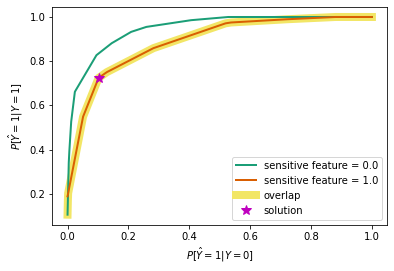

In [29]:
fairlearn.postprocessing.plot_threshold_optimizer(post_unc, ax=None, show_plot=True)

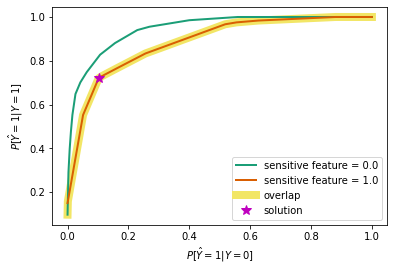

In [30]:
fairlearn.postprocessing.plot_threshold_optimizer(post_con, ax=None, show_plot=True)

In [31]:
from fairlearn.metrics import equalized_odds_difference
# equalized odds fairness metric is to ensure a machine learning model performs equally 
# well for different groups
# The greater of two metrics: true_positive_rate_difference and false_positive_rate_difference
# The equalized odds difference of 0 means that all groups have the same true positive, true negative, false positive, and false negative rates.

print('Unconstrained', equalized_odds_difference(test_set['labels'],
                                post_unc_preds,
                                sensitive_features=test_set["groups"]==1))

print('Constrained', equalized_odds_difference(test_set['labels'],
                                post_con_preds,
                                sensitive_features=test_set["groups"]==1))

Unconstrained 0.05671137157669334
Constrained 0.04208272286712497


In [32]:
# true positive rates
print('Unconstrained', fairlearn.metrics.true_positive_rate(test_set['labels'], post_unc_preds))
print('Constrained', fairlearn.metrics.true_positive_rate(test_set['labels'], post_con_preds))

Unconstrained 0.6610169491525424
Constrained 0.652542372881356


In [33]:
# demographic parity
print('Unconstrained', fairlearn.metrics.demographic_parity_difference(test_set['labels'], 
                                                                       post_unc_preds,
                                                                      sensitive_features=test_set["groups"]==1))
print('Constrained', fairlearn.metrics.demographic_parity_difference(test_set['labels'], 
                                                                     post_con_preds,
                                                                    sensitive_features=test_set["groups"]==1))

Unconstrained 0.28113553113553114
Constrained 0.27075702075702074


In [34]:
# False negatives and false positives

# Unconstrained
fn = fairlearn.metrics.false_negative_rate(test_set['labels'], post_unc_preds)
fp = fairlearn.metrics.false_positive_rate(test_set['labels'], post_unc_preds)
print('Unconstrained', 'FN', fn, 'FP', fp)

# Constrained
fn = fairlearn.metrics.false_negative_rate(test_set['labels'], post_con_preds)
fp = fairlearn.metrics.false_positive_rate(test_set['labels'], post_con_preds)
print('Constrained', 'FN', fn, 'FP', fp)

Unconstrained FN 0.3389830508474576 FP 0.1423487544483986
Constrained FN 0.3474576271186441 FP 0.13345195729537365


In [35]:
from fairlearn.metrics import MetricFrame
from sklearn.metrics import accuracy_score

# unconstrained
accuracy_summary = MetricFrame(metrics=accuracy_score,
                               y_true=test_set['labels'],
                               y_pred=post_unc_preds,
                               sensitive_features=test_set["groups"]==1)

print('Unconstrained', accuracy_summary.overall)
print(accuracy_summary.by_group)

Unconstrained 0.7994987468671679
sensitive_feature_0
False    0.835165
True     0.722222
Name: accuracy_score, dtype: object


In [36]:
# constrained
accuracy_summary = MetricFrame(metrics=accuracy_score,
                               y_true=test_set['labels'],
                               y_pred=post_con_preds,
                               sensitive_features=test_set["groups"]==1)

print('Constrained', accuracy_summary.overall)
print(accuracy_summary.by_group)

Constrained 0.8032581453634086
sensitive_feature_0
False    0.840659
True     0.722222
Name: accuracy_score, dtype: object



Overall accuracy: 79.95%
Group 0: 83.52%
Group 1: 72.22%

Sensitivity / True positive rate:
Group 0: 64.56%
Group 1: 66.88%


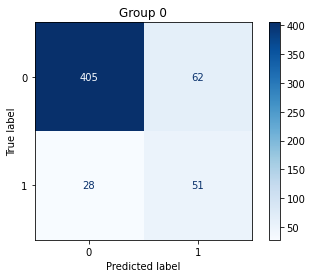

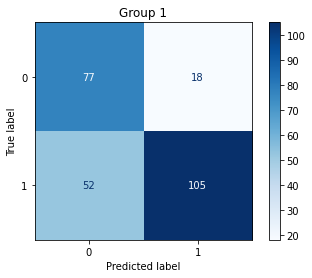

In [37]:
# unconstrained
get_stats(test_set['features'], test_set['labels'], post_unc, test_set["groups"]==1, post_unc_preds)


Overall accuracy: 80.33%
Group 0: 84.07%
Group 1: 72.22%

Sensitivity / True positive rate:
Group 0: 64.56%
Group 1: 65.61%


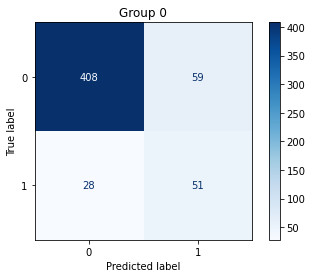

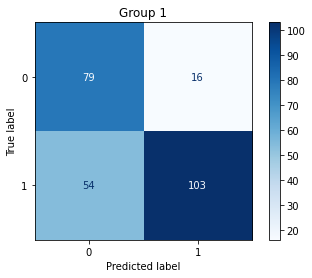

In [38]:
# constrained
get_stats(test_set['features'], test_set['labels'], post_con, test_set["groups"]==1, post_con_preds)

In [39]:
# attempting to force display prediction outcomes, didn't work
# d = paired_test_set['dimension']
# s0 = model_con.predict(paired_test_set['features'][:, 0, 0:d].reshape(-1, d))
# s1 = model_con.predict(paired_test_set['features'][:, 1, 0:d].reshape(-1, d))
# diff = s0 - s1  
# np.mean(diff.reshape((-1)) < 0)
# evaluate_results(model_con, paired_test_set, model_params)
# train_model(paired_train_set, model_params)
# paired_batch = {}
# batch_index = 9
# features = lambda: paired_batch['features'] 
# ranking_model, predictions = create_ranking_model(features, train_set['dimension'])

In [42]:
# predictions

## (2) Pairwise Equal Opportunity

Recall that we denote
 $err_{i,j}(f)$ as the ranking error over positive-negative document pairs where the pos. document is from group $i$, and the neg. document is from group $j$.
$$
err_{i, j}(f) ~=~ \mathbf{E}\big[\mathbb{I}\big(f(x) < f(x')\big) \,\big|\, y = 1,~ y' = 0,~ grp(x) = i, ~grp(x') = j\big]
$$


We first constrain only the cross-group errors, highlighted below.

<br>
<table border='1' bordercolor='black'>
  <tr >
     <td bgcolor='white'> </td>
     <td bgcolor='white'> </td>
     <td bgcolor='white'  colspan=2 align=center><b>Negative</b></td>
  </tr>
  <tr>
    <td bgcolor='white'></td>
    <td bgcolor='white'></td>
    <td>Group 0</td>
    <td>Group 1</td>
  </tr>
  <tr>
    <td bgcolor='white' rowspan=2><b>Positive</b></td>
    <td bgcolor='white'>Group 0</td>
    <td bgcolor='white'>$err_{0,0}$</td>
    <td bgcolor='white'>$\mathbf{err_{0,1}}$</td>
  </tr>
  <tr>
    <td>Group 1</td>
     <td bgcolor='white'>$\mathbf{err_{1,0}}$</td>
      <td bgcolor='white'>$err_{1,1}$</td>
  </tr>
</table>
<br>

The optimization problem we solve constraints the cross-group pairwise errors to be similar:

$$min_f\; err(f)$$
$$\text{s.t. }\;\; |err_{0,1}(f) - err_{1,0}(f)| \leq 0.05$$


In [43]:
# Model hyper-parameters.
model_params = {
    'loops': 10, 
    'iterations_per_loop': 250, 
    'learning_rate': 0.1,
    'constraint_type': 'cross_group_equal_opportunity', 
    'constraint_slack': 0.05,
    'dual_scale': 0.1}

# Unconstrained optimization.
model_params['constrained'] = False
model_unc  = train_model(paired_train_set, model_params)
display_results(model_unc, paired_train_set, model_params, 'Unconstrained     ', 
                'Train', show_header=True)
display_results(model_unc, paired_test_set, model_params,  'Unconstrained     ', 
                'Test')

# Constrained optimization with TFCO.
model_params['constrained'] = True
model_con  = train_model(paired_train_set, model_params)
display_results(model_con, paired_train_set, model_params, 'Constrained     ', 
                'Train', show_header=True)
display_results(model_con, paired_test_set, model_params, 'Constrained     ', 
                'Test')


 Loop 9: error = 0.054, max constraint violation = 0.095

Method			Error		Overall		Group 0/1	Group 1/0	Diff
Unconstrained     	Train		0.054		0.267		0.122		0.145
Unconstrained     	Test		0.082		0.314		0.136		0.178

 Loop 9: error = 0.071, max constraint violation = -0.046

Method			Error		Overall		Group 0/1	Group 1/0	Diff
Constrained     	Train		0.071		0.122		0.126		0.004
Constrained     	Test		0.114		0.207		0.161		0.046


In [44]:
sensitive_features = train_set['groups']
X = train_set['features']
y = train_set['labels']

np.random.seed(121)
#unconstrained
postprocess_est_unc = ThresholdOptimizer(
                   estimator=model_unc,
                   constraints="equalized_odds",
                   objective="balanced_accuracy_score",
                   prefit=True,
                   predict_method='auto')

post_unc = postprocess_est_unc.fit(X, y, sensitive_features=sensitive_features)
post_unc_preds = post_unc.predict(test_set['features'], sensitive_features = test_set['groups'])

np.random.seed(121)
#constrained
postprocess_est_con = ThresholdOptimizer(
                   estimator=model_con,
                   constraints="equalized_odds",
                   objective="balanced_accuracy_score",
                   prefit=True,
                   predict_method='auto')

post_con = postprocess_est_con.fit(X, y, sensitive_features=sensitive_features)
post_con_preds = post_con.predict(test_set['features'], sensitive_features = test_set['groups'])

/opt/conda/lib/python3.7/site-packages/fairlearn/postprocessing/_threshold_optimizer.py:309: UserWarning: The value of `prefit` is `True`, but `check_is_fitted` raised `NotFittedError` on the base estimator.

If the provided base estimator has been fitted, this could mean that (1) its implementation does not conform to the sklearn estimator API, or (2) the enclosing ThresholdOptimizer has been cloned (for instance by `sklearn.model_selection.cross_validate`).

In case (1), please file an issue with the base estimator developers, but continue to use the enclosing ThresholdOptimizer with `prefit=True`. In case (2), please use `prefit=False`.
  type(self).__name__
/opt/conda/lib/python3.7/site-packages/fairlearn/postprocessing/_interpolated_thresholder.py:115: UserWarning: The value of `prefit` is `True`, but `check_is_fitted` raised `NotFittedError` on the base estimator.

If the provided base estimator has been fitted, this could mean that (1) its implementation does not conform to the 

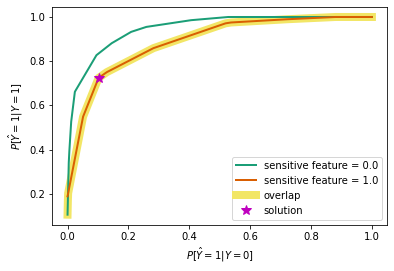

In [45]:
fairlearn.postprocessing.plot_threshold_optimizer(post_unc, ax=None, show_plot=True)

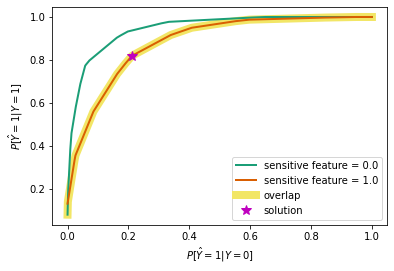

In [46]:
fairlearn.postprocessing.plot_threshold_optimizer(post_con, ax=None, show_plot=True)

In [47]:
# from fairlearn.metrics import equalized_odds_difference
# equalized odds fairness metric is to ensure a machine learning model performs equally 
# well for different groups
# The greater of two metrics: true_positive_rate_difference and false_positive_rate_difference
# The equalized odds difference of 0 means that all groups have the same true positive, true negative, false positive, and false negative rates.

print('Unconstrained', equalized_odds_difference(test_set['labels'],
                                post_unc_preds,
                                sensitive_features=test_set["groups"]==1))

print('Constrained', equalized_odds_difference(test_set['labels'],
                                post_con_preds,
                                sensitive_features=test_set["groups"]==1))

Unconstrained 0.0652766820691987
Constrained 0.004147413501634167


In [48]:
# true positive rates
print('Unconstrained', fairlearn.metrics.true_positive_rate(test_set['labels'], post_unc_preds))
print('Constrained', fairlearn.metrics.true_positive_rate(test_set['labels'], post_con_preds))

Unconstrained 0.652542372881356
Constrained 0.7203389830508474


In [49]:
# demographic parity
print('Unconstrained', fairlearn.metrics.demographic_parity_difference(test_set['labels'], 
                                                                       post_unc_preds,
                                                                      sensitive_features=test_set["groups"]==1))
print('Constrained', fairlearn.metrics.demographic_parity_difference(test_set['labels'], 
                                                                     post_con_preds,
                                                                    sensitive_features=test_set["groups"]==1))

Unconstrained 0.2921245421245421
Constrained 0.22466422466422464


In [50]:
# False negatives and false positives

# Unconstrained
fn = fairlearn.metrics.false_negative_rate(test_set['labels'], post_unc_preds)
fp = fairlearn.metrics.false_positive_rate(test_set['labels'], post_unc_preds)
print('Unconstrained', 'FN', fn, 'FP', fp)

# Constrained
fn = fairlearn.metrics.false_negative_rate(test_set['labels'], post_con_preds)
fp = fairlearn.metrics.false_positive_rate(test_set['labels'], post_con_preds)
print('Constrained', 'FN', fn, 'FP', fp)

Unconstrained FN 0.3474576271186441 FP 0.13523131672597866
Constrained FN 0.2796610169491525 FP 0.24555160142348753


In [51]:
from fairlearn.metrics import MetricFrame
from sklearn.metrics import accuracy_score

# unconstrained
accuracy_summary = MetricFrame(metrics=accuracy_score,
                               y_true=test_set['labels'],
                               y_pred=post_unc_preds,
                               sensitive_features=test_set["groups"]==1)

print('Unconstrained', accuracy_summary.overall)
print(accuracy_summary.by_group)

Unconstrained 0.8020050125313283
sensitive_feature_0
False    0.838828
True     0.722222
Name: accuracy_score, dtype: object


In [52]:
# constrained
accuracy_summary = MetricFrame(metrics=accuracy_score,
                               y_true=test_set['labels'],
                               y_pred=post_con_preds,
                               sensitive_features=test_set["groups"]==1)

print('Constrained', accuracy_summary.overall)
print(accuracy_summary.by_group)

Constrained 0.7443609022556391
sensitive_feature_0
False    0.749084
True     0.734127
Name: accuracy_score, dtype: object



Overall accuracy: 80.2%
Group 0: 83.88%
Group 1: 72.22%

Sensitivity / True positive rate:
Group 0: 62.03%
Group 1: 66.88%


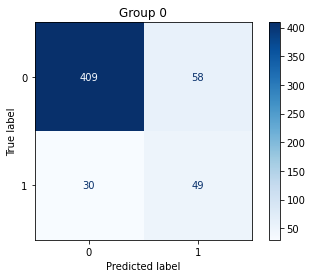

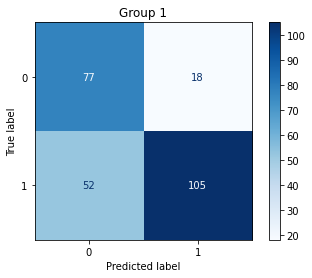

In [53]:
# unconstrained
get_stats(test_set['features'], test_set['labels'], post_unc, test_set["groups"]==1, post_unc_preds)


Overall accuracy: 74.44%
Group 0: 74.91%
Group 1: 73.41%

Sensitivity / True positive rate:
Group 0: 72.15%
Group 1: 71.97%


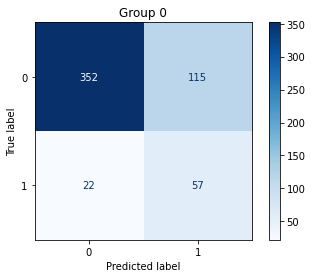

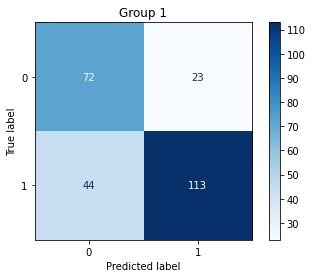

In [54]:
# constrained
get_stats(test_set['features'], test_set['labels'], post_con, test_set["groups"]==1, post_con_preds)